---
title: "HDA Tutorial"
subtitle: "This notebook demonstrates the first steps using the Harmonised Data access API."
author: "Author: Eumetsat"
tags: [HDA, STAC, Core API]
thumbnail: ../../img/hda.png
license: MIT
copyright: "© 2024 EUMETSAT"
---
<div style="margin: 6px 0;">
  <a href="https://jupyter.central.data.destination-earth.eu/user-redirect/lab/tree/DestinE-DataLake-Lab/REST/HDA-REST-full-version.ipynb" target="_blank" style="text-decoration: none;">
    <span class="launch">🚀 Launch in JupyterHub</span>
  </a>
</div>

<div class="alert alert-block alert-success">
<h3>First steps using Harmonised Data access API</h3>
<li> Discover data of DestinE Data Portfolio </li>
<li> Search data of DestinE Data Portfolio and visualize the results</li>
<li> Access Data of DestinE Data Portfolio and visualize the thumbnails</li>
</div>

This notebook demonstrates how to use the HDA (Harmonized Data Access) API by sending a few HTTP requests to the API, using Python code.

Throughout this quickstart notebook, you will learn:

1. [Discover](#Discover): How to discover *DEDL* services and data collections through HDA.
2. [Authenticate](#Authenticate): How to authenticate to search and access *DEDL* collections. 
3. [Search data](#Search):  How to search *DEDL* data through HDA.
4. [Viisualize search results](#Visualize): How to see the results.
4. [Download data](#Download): How to download *DEDL* data through HDA.

The detailed API and definition of each endpoint and parameters is available in the HDA Swagger UI at:

https://hda.data.destination-earth.eu/docs/


<div class="alert alert-block alert-warning">
<b> Prerequisites: </b>
<li> For Data discovery: none </li>
<li> For Data access : <a href="https://platform.destine.eu/"> DestinE user account</a> </li>
</div>

## Discover

### Settings
#### Import the relevant modules
We start off by importing the relevant modules for HTTP requests and json handling.

In [1]:
from typing import Union
import requests
import json
import urllib.parse
from IPython.display import JSON
from IPython.display import Image

import geopandas
import folium
import folium.plugins
from branca.element import Figure
import shapely.geometry

#### Define some constants for the API URLs
In this section, we define the relevant constants, holding the URL strings for the different endpoints.

In [2]:
# IDS
SERVICE_ID = "dedl-hook"
COLLECTION_ID = "EO.EUM.DAT.SENTINEL-3.SL_1_RBT___"
ITEM_ID = "S3B_SL_1_RBT____20240918T102643_20240918T102943_20240919T103839_0179_097_336_2160_PS2_O_NT_004"

# Core API
HDA_API_URL = "https://hda.data.destination-earth.eu"
SERVICES_URL = f"{HDA_API_URL}/services"
SERVICE_BY_ID_URL = f"{SERVICES_URL}/{SERVICE_ID}"

# STAC API
## Core
STAC_API_URL = f"{HDA_API_URL}/stac/v2"
CONFORMANCE_URL = f"{STAC_API_URL}/conformance"

## Item Search
SEARCH_URL = f"{STAC_API_URL}/search"
DOWNLOAD_URL = f"{STAC_API_URL}/download"

## Collections
COLLECTIONS_URL = f"{STAC_API_URL}/collections"
COLLECTION_BY_ID_URL = f"{COLLECTIONS_URL}/{COLLECTION_ID}"

## Items
COLLECTION_ITEMS_URL = f"{COLLECTIONS_URL}/{COLLECTION_ID}/items"
COLLECTION_ITEM_BY_ID_URL = f"{COLLECTIONS_URL}/{COLLECTION_ID}/items/{ITEM_ID}"

## HTTP Success
HTTP_SUCCESS_CODE = 200

### Core API

We can start off by requesting the HDA landing page, which provides links to the API definition, the available services  (links `services` and `service-doc`) as well as the STAC API index.  

In [3]:
response=requests.get(HDA_API_URL)
JSON(response.json())

<IPython.core.display.JSON object>

### STAC API
The HDA is plugged to a STAC API.
The STAC API entry point is set to the `/stac` endpoint and provides the search capabilities provided by the DEDL STAC interface.

In [4]:
print(STAC_API_URL)
JSON(requests.get(STAC_API_URL).json())

https://hda.data.destination-earth.eu/stac/v2


<IPython.core.display.JSON object>

### Discover DEDL Services

The `/services` endpoint will return the list of the DEDL services available for users of the platform.

In [5]:
print(SERVICES_URL)
JSON(requests.get(SERVICES_URL).json())

https://hda.data.destination-earth.eu/services


<IPython.core.display.JSON object>

Through the `/services` endpoint is also possible discover services related to a certain topic:

In [6]:
JSON(requests.get(SERVICES_URL,params = {"q": "dask"}).json())

<IPython.core.display.JSON object>

The API can also describe a specific service, identified by its `serviceID` (e.g. **dedl-hook**). 

The links `describes` and `described by` contains the reference documentation.

In [7]:
print(SERVICE_BY_ID_URL)
JSON(requests.get(SERVICE_BY_ID_URL).json())

https://hda.data.destination-earth.eu/services/dedl-hook


<IPython.core.display.JSON object>

### Discover DEDL data collections

It is also possible discover data collections related to a certain topic and provided by a certain provider in a specic time interval.
We specify an open time interval in order to have collections with data starting from a certain datetime.

In [8]:
response = requests.get(COLLECTIONS_URL,params = {"q": "ozone,methane,fire","provider":"eumetsat","datetime":'2024-01-01T00:00:00Z/..'})

JSON(response.json(), expanded=False)

<IPython.core.display.JSON object>

## Authenticate
### Obtain Authentication Token

In [9]:
import json
import os
from getpass import getpass
import destinelab as deauth

DESP_USERNAME = input("Please input your DESP username or email: ")
DESP_PASSWORD = getpass("Please input your DESP password: ")

auth = deauth.AuthHandler(DESP_USERNAME, DESP_PASSWORD)
access_token = auth.get_token()
if access_token is not None:
    print("DEDL/DESP Access Token Obtained Successfully")
else:
    print("Failed to Obtain DEDL/DESP Access Token")

auth_headers = {"Authorization": f"Bearer {access_token}"}

Please input your DESP username or email:  eum-dedl-user
Please input your DESP password:  ········


Response code: 200
DEDL/DESP Access Token Obtained Successfully


## Search

### List Available Collections
The `/stac/collections` endpoint returns a `FeatureCollection` object, listing all STAC collections available to the user.

In [10]:
print(COLLECTIONS_URL)
JSON(requests.get(COLLECTIONS_URL).json())

https://hda.data.destination-earth.eu/stac/v2/collections


<IPython.core.display.JSON object>

By providing a specific `collectionID` (e.g. **EO.EUM.DAT.SENTINEL-3.SL_1_RBT___**), the user can get the metadata for a specific `Collection`.
The collection used for this tutorial is [SLSTR Level 1B Radiances and Brightness Temperatures - Sentinel-3](https://hda.data.destination-earth.eu/ui/dataset/EO.EUM.DAT.SENTINEL-3.SL_1_RBT___)

In [11]:
print(COLLECTION_BY_ID_URL)
JSON(requests.get(COLLECTION_BY_ID_URL).json())

https://hda.data.destination-earth.eu/stac/v2/collections/EO.EUM.DAT.SENTINEL-3.SL_1_RBT___


<IPython.core.display.JSON object>

### Search for Items in a specific collection
It is also possible to get the list of items available in a given `Collection` using a simple search and **sorting** the results.


In [12]:
FILTER = "?datetime=2024-09-18T00:00:00Z/2024-09-20T23:59:59Z&bbox=-10,34,-5,42.5&sortby=datetime&limit=5"

print(COLLECTION_ITEMS_URL+FILTER)
response=requests.get(COLLECTION_ITEMS_URL+FILTER, headers=auth_headers)  

JSON(response.json())            

https://hda.data.destination-earth.eu/stac/v2/collections/EO.EUM.DAT.SENTINEL-3.SL_1_RBT___/items?datetime=2024-09-18T00:00:00Z/2024-09-20T23:59:59Z&bbox=-10,34,-5,42.5&sortby=datetime&limit=5


<IPython.core.display.JSON object>

### The search endpoint
The STAC API also provides an item endpoint (`/stac/search`).
This endpoint allows users to efficiently search for items that match the specified input filters.

By default, the `/stac/search` endpoint will return the first 20 items found in all the collections available at the `/stac/collections` endpoint.
Filters can be added either via query parameters in a **GET** request or added to the JSON body of a **POST** request.

The full detail for each available filter is available in the [API documentation](https://hda.data.destination-earth.eu/docs/#/STAC%20API%20-%20Item%20Search/getItemSearch).

The query parameters are added at the end of the URL as a *query string*: `?param1=val1&param2=val2&param3=val3`

In [13]:
FILTER = "&datetime=2024-09-18T00:00:00Z/2024-09-20T23:59:59Z&bbox=-10,34,-5,42.5&sortby=datetime&limit=10"
SEARCH_QUERY_STRING = "?collections="+COLLECTION_ID+FILTER
response=requests.get(SEARCH_URL + SEARCH_QUERY_STRING, headers=auth_headers)

JSON(response.json())    

<IPython.core.display.JSON object>

The same filters can be added as the JSON body of a **POST** request.

In [14]:
BODY = {
    "collections": [
        COLLECTION_ID,
    ],
    "datetime" : "2024-09-18T00:00:00Z/2024-09-20T23:59:59Z",
    "bbox": [-10,34,
              -5,42.5 ],
    "sortby": [{"field": "datetime","direction": "desc"}
              ],
    "limit": 10,
}

response=requests.post(SEARCH_URL, json=BODY, headers=auth_headers)

JSON(response.json())    

<IPython.core.display.JSON object>

## Visualize

### Visualize search results in a table

Search results can be visualized on a map.

In [15]:
df = geopandas.GeoDataFrame.from_features(response.json()['features'], crs="epsg:4326")
df.head()

geometry order:status platform  \
0  POLYGON ((-19.0905 30.7017, -18.9041 30.7463, ...    succeeded        B   
1  POLYGON ((-13.0659 51.3191, -11.5468 48.8192, ...    succeeded        A   
2  POLYGON ((-7.63857 41.0981, -6.56759 38.5413, ...    succeeded        A   
3  POLYGON ((-10.2243 28.6756, -9.36337 31.257, -...    succeeded        B   
4  POLYGON ((-6.44212 39.1077, -5.33213 41.6566, ...    succeeded        B   

  storage:tier product:timeliness  eo:cloud_cover processing:level  \
0       online                 NT       61.338021               L1   
1       online                 NT       47.518299               L1   
2       online                 NT       65.984271               L1   
3       online                 NT       67.402847               L1   
4       online                 NT       70.961736               L1   

                     published sat:orbit_state  sat:absolute_orbit  ...  \
0  2024-09-21T23:05:47.191285Z       ASCENDING               33369  ...   
1  2024-09-22T08:14:04.882197Z       ASCENDING               44762  ...   
2  2024-09-22T08:13:55.240337Z       ASCENDING               44762  ...   
3  2024-09-21T11:07:12.780243Z      DESCENDING               33362  ...   
4  2024-09-21T11:06:01.960022Z      DESCENDING               33362  ...   

   cycleNumber coastalCover processorVersion salineWaterCover  \
0           97     0.947396              3.5        87.500000   
1          117     4.129583              3.5        46.585451   
2          117     2.361146              3.5        35.067778   
3           97     0.352917              3.5        96.457257   
4           97     0.750694              3.5        90.440278   

  tidalRegionCover baselineCollection freshInlandWaterCover  \
0         0.281910                004              0.090625   
1         4.054201                004              0.365347   
2         0.004444                004              0.482569   
3         0.128125                004              0.029444   
4         0.465729                004              0.054236   

             beginningDateTime               endingDateTime  \
0  2024-09-20T22:35:14.835178Z  2024-09-20T22:38:14.835178Z   
1  2024-09-20T21:36:01.380515Z  2024-09-20T21:39:01.380515Z   
2  2024-09-20T21:33:01.380515Z  2024-09-20T21:36:01.380515Z   
3  2024-09-20T11:18:20.197528Z  2024-09-20T11:21:20.197528Z   
4  2024-09-20T11:15:20.197528Z  2024-09-20T11:18:20.197528Z   

  federation:backends  
0      [external_fdp]  
1      [external_fdp]  
2      [external_fdp]  
3      [external_fdp]  
4      [external_fdp]  

[5 rows x 39 columns]

### Visualize search results in a map

In [16]:
#map1 = folium.Map([38, 0],
#                  zoom_start=4, tiles='Esri Ocean Basemap', attr='Tiles &copy; Esri &mdash; Source: Esri, DeLorme, NAVTEQ')

#map1 = folium.Map([38, 0],zoom_start=4)

map1 = folium.Map([38, 0],zoom_start=4, tiles=None)

nasa_wms = folium.WmsTileLayer(
    url='https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi',
    name='NASA Blue Marble',
    layers='BlueMarble_ShadedRelief',
    format='image/png',
    transparent=True,
    attr='NASA'
)
nasa_wms.add_to(map1)

results=folium.GeoJson( response.json(),name='Search results',style_function=lambda feature: {
        "fillColor": "#005577",
        "color": "black",
        "weight": 1
    })

results.add_to(map1)


bbox=[-10,34,-5,42.5]
bb=folium.GeoJson(
    shapely.geometry.box(*bbox),name='Search bounding box',style_function=lambda feature: {
        "fillColor": "#ff0000",
        "color": "black",
        "weight": 2,
        "dashArray": "5, 5",
    }
)
bb.add_to(map1)

# Add layer control to toggle visibility
folium.LayerControl().add_to(map1)


#display(fig)
map1


## Download

The items belonging to a specific collection can be downloaded entirely, or it is possible to download a single asset of a chosen item.

### Download a specific item
To get the metadata specific to a given item (identified by its `itemID` in a collection, the user can request the `/stac/collections/{collectionID}/items/{itemID}`endpoint.

In [17]:
print(COLLECTION_ITEM_BY_ID_URL)
response=requests.get(COLLECTION_ITEM_BY_ID_URL, headers=auth_headers) 
JSON(response.json())             

https://hda.data.destination-earth.eu/stac/v2/collections/EO.EUM.DAT.SENTINEL-3.SL_1_RBT___/items/S3B_SL_1_RBT____20240918T102643_20240918T102943_20240919T103839_0179_097_336_2160_PS2_O_NT_004


<IPython.core.display.JSON object>

The metadata of a given item contains also the download link that the user can use to download a specific item.

In [18]:
result = json.loads(response.text)
downloadUrl = result['assets']['downloadLink']['href']
print(downloadUrl)

resp_dl = requests.get(downloadUrl,stream=True,headers=auth_headers)

# If the request was successful, download the file
if (resp_dl.status_code == HTTP_SUCCESS_CODE):
        print("Downloading "+ ITEM_ID + "...")
        filename = ITEM_ID + ".zip"
        with open(filename, 'wb') as f:
            for chunk in resp_dl.iter_content(chunk_size=1024): 
                if chunk:
                    f.write(chunk)
                    f.flush()
        print("The dataset has been downloaded to: {}".format(filename))
else: print("Request Unsuccessful! Error-Code: {}".format(response.status_code))

https://hda-download.lumi.data.destination-earth.eu/data/external_fdp/EO.EUM.DAT.SENTINEL-3.SL_1_RBT___/S3B_SL_1_RBT____20240918T102643_20240918T102943_20240919T103839_0179_097_336_2160_PS2_O_NT_004/downloadLink
The dataset has been downloaded to: S3B_SL_1_RBT____20240918T102643_20240918T102943_20240919T103839_0179_097_336_2160_PS2_O_NT_004.zip


### Download a specific asset of an item
The metadata of a given item contains also the single assets download link, that the user can use to download a specific asset of the chosen item.
In the example below we download the asset: "xfdumanifest.xml"

In [19]:
downloadUrl = result['assets']['xfdumanifest.xml']['href']
print(downloadUrl)

resp_dl = requests.get(downloadUrl,stream=True,headers=auth_headers)

# If the request was successful, download the file
if (resp_dl.status_code == HTTP_SUCCESS_CODE):
        print("Downloading "+ result['assets']['xfdumanifest.xml']['title'] + "...")
        filename = result['assets']['xfdumanifest.xml']['title']
        with open(filename, 'wb') as f:
            for chunk in resp_dl.iter_content(chunk_size=1024): 
                if chunk:
                    f.write(chunk)
                    f.flush()
        print("The dataset has been downloaded to: {}".format(filename))
else: print("Request Unsuccessful! Error-Code: {}".format(response.status_code))

https://hda-download.lumi.data.destination-earth.eu/data/external_fdp/EO.EUM.DAT.SENTINEL-3.SL_1_RBT___/S3B_SL_1_RBT____20240918T102643_20240918T102943_20240919T103839_0179_097_336_2160_PS2_O_NT_004/xfdumanifest.xml
The dataset has been downloaded to: xfdumanifest.xml


### Visualize the quicklook asset

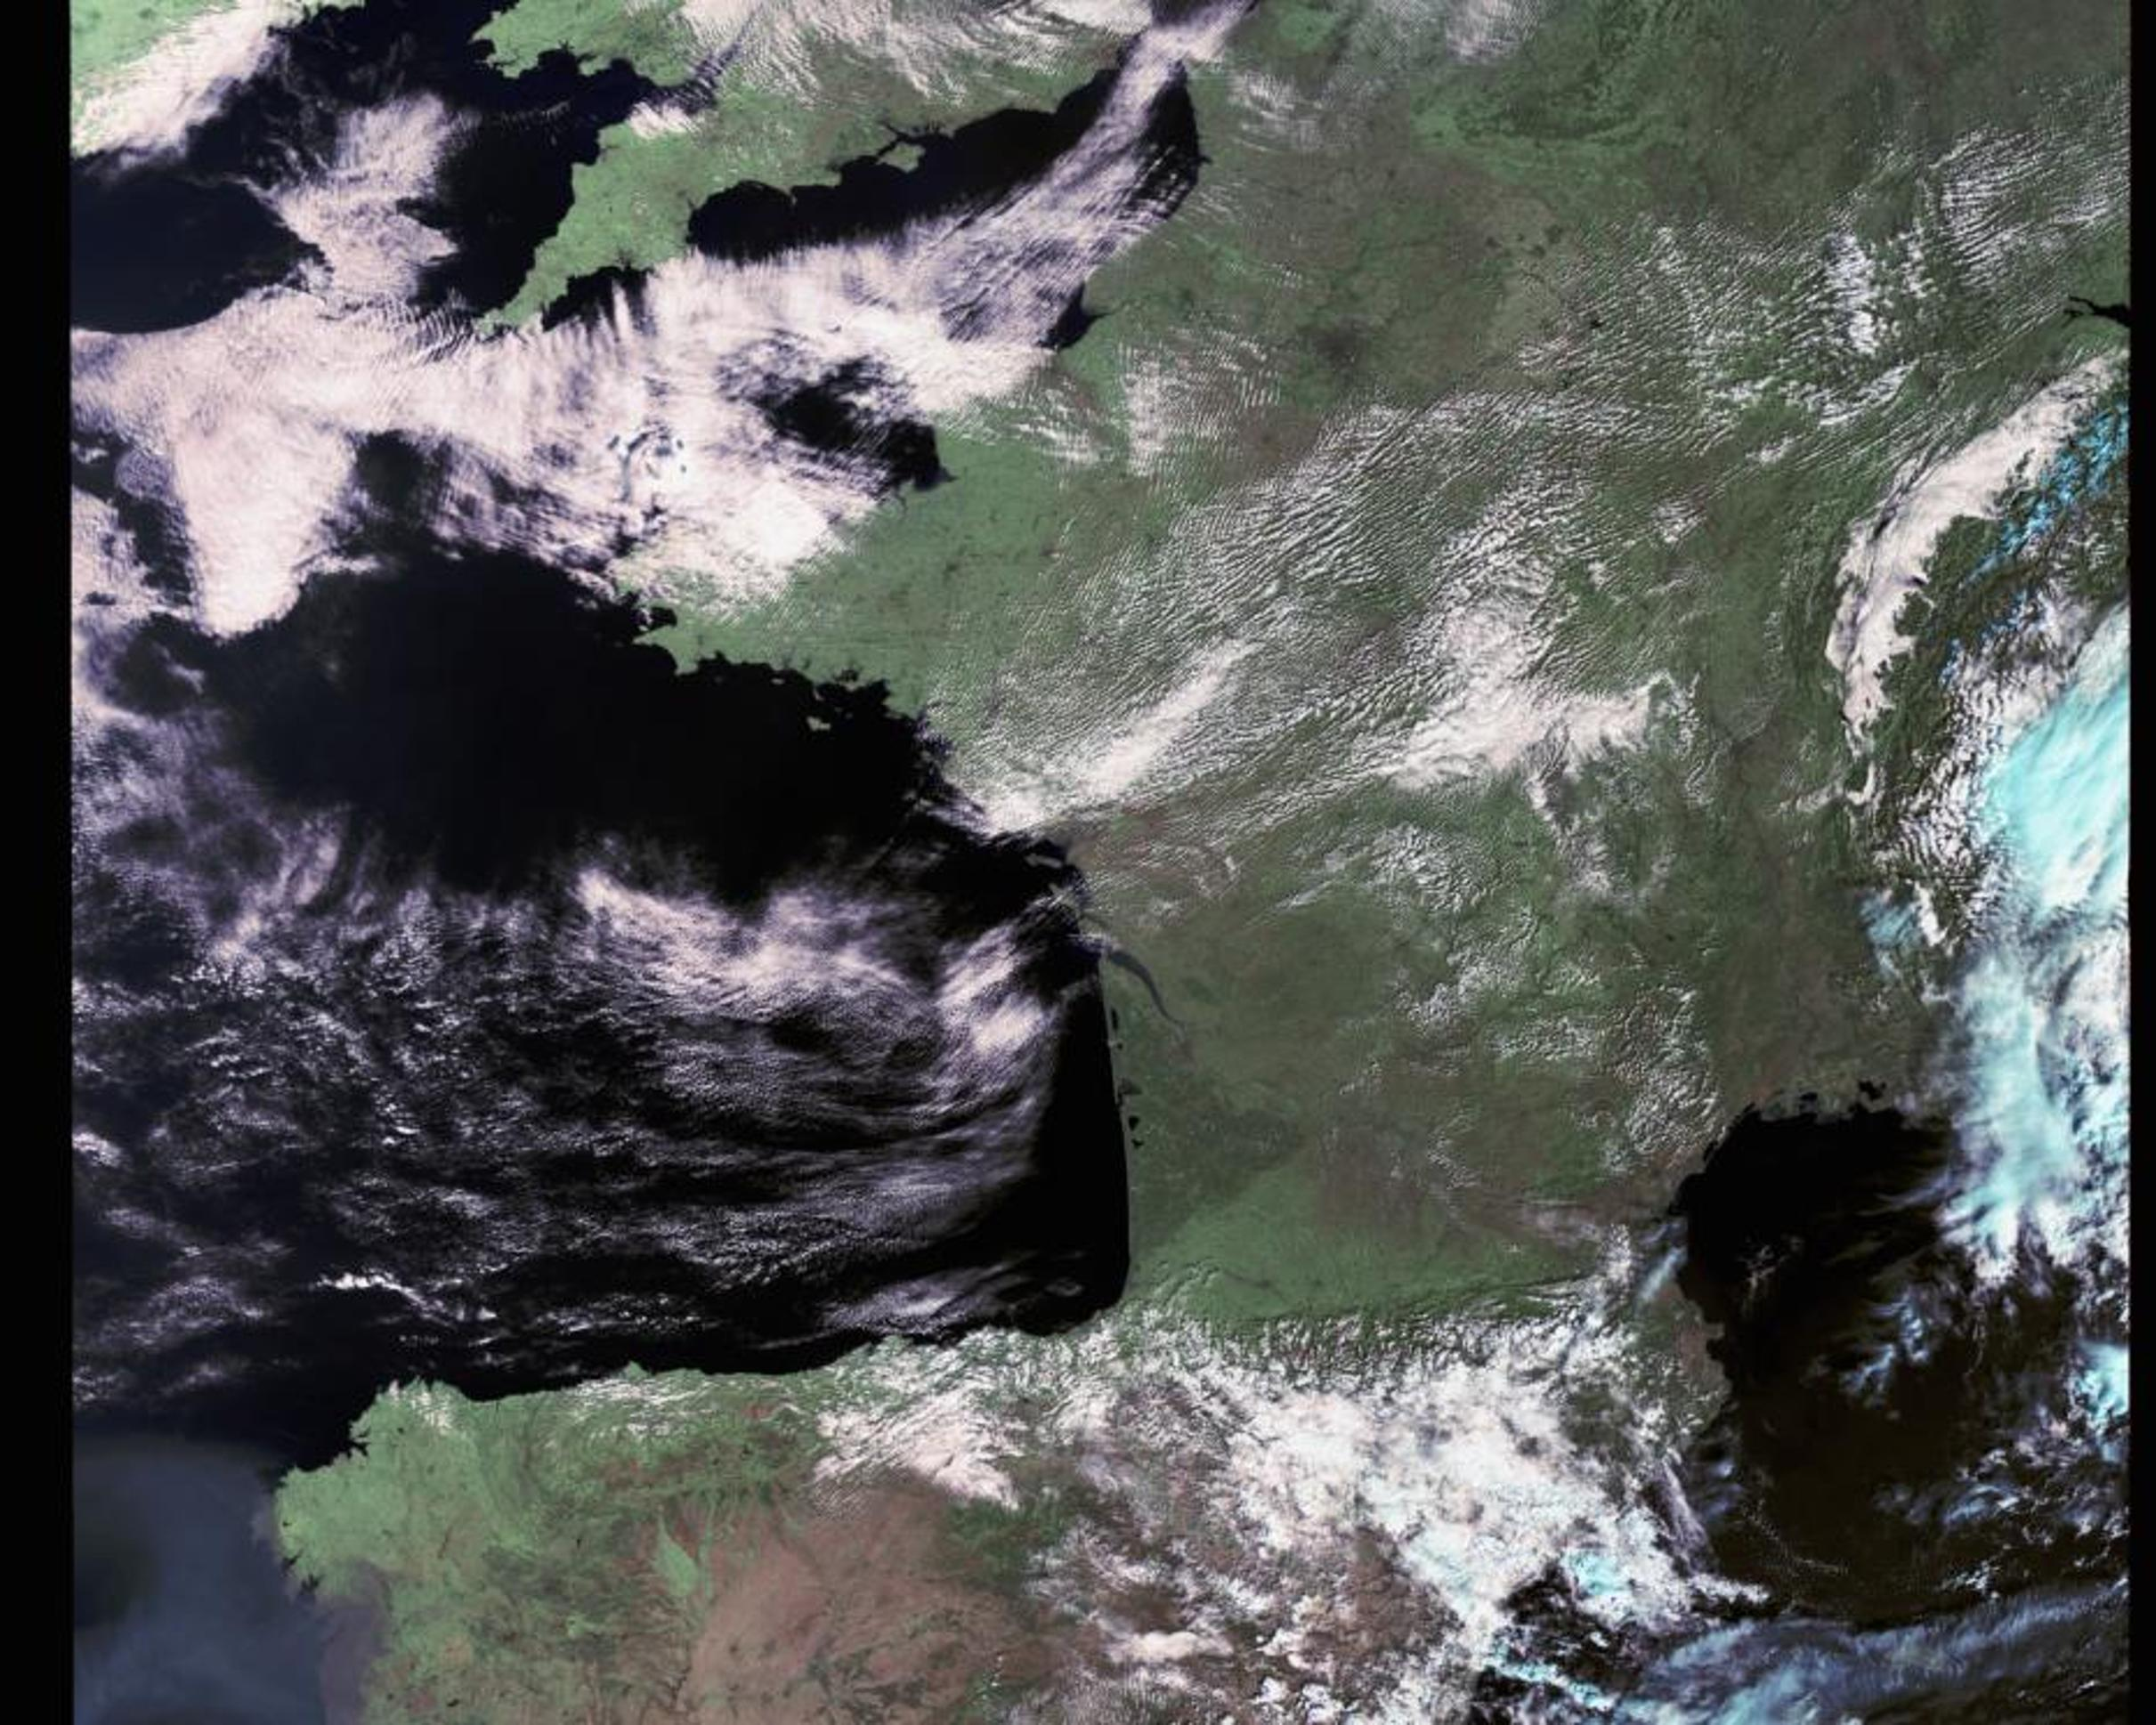

In [28]:
url =result['assets']["quicklook.jpg"]["href"]
headers = {
    "Authorization": "Bearer " + access_token
}

response = requests.get(url, headers=headers)
response.raise_for_status()

Image(data=response.content,width=500)